# Brain Tumor Detection Using a Convolutional Neural Network

### Import Modules

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### Data Preparation

Found 1695 files belonging to 4 classes.
Found 246 files belonging to 4 classes.
Found 502 files belonging to 4 classes.
['glioma', 'meningioma', 'no_tumor', 'pituitary']


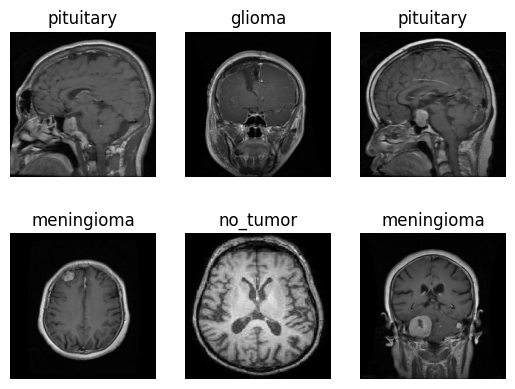

In [3]:
# Dataset path
train_dir = r"C:\Users\FixTest\Downloads\train-20250724T132009Z-1-001\train"
test_dir = r"C:\Users\FixTest\Downloads\test-20250724T132009Z-1-001\test"
valid_dir = r"C:\Users\FixTest\Downloads\valid-20250724T132012Z-1-001\valid"

# Load Datasets
IMG_SIZE = (224,224)
BATCH_SIZE = 40

train_img = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=42,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_img = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=42,
    shuffle=False,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

valid_img = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    seed=42,
    shuffle=False,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_img.class_names
print(class_names)

for images, labels in train_img.take(1):
    plt.figure()
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        # print("Min:", tf.reduce_min(images).numpy())
        # print("Max:", tf.reduce_max(images).numpy())

### Data Preprocessing & Augmentation

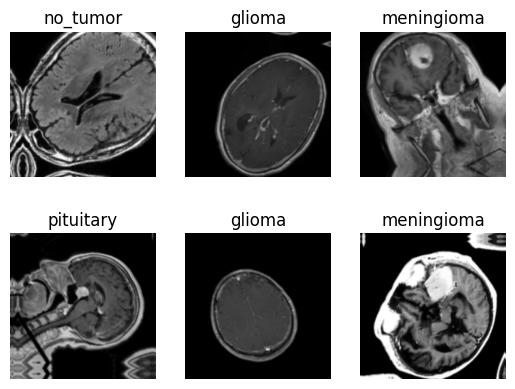

In [4]:
# Data Augmentation (no rescaling yet)
data_augmentation = tf.keras.Sequential([
  layers.RandomContrast(0.2),
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomTranslation(0.1, 0.1)
])

# Final preprocessing pipeline
preprocess = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255)
])

# Apply it to training data only
train_img = train_img.map(
    lambda x, y: (preprocess(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Only normalize test/valid
normalization_layer = tf.keras.layers.Rescaling(1./255)
test_img = test_img.map(lambda x, y: (normalization_layer(x), y))
valid_img = valid_img.map(lambda x, y: (normalization_layer(x), y))

# Caching and Prefetching to improve training speed
AUTOTUNE = tf.data.AUTOTUNE
train_img = train_img.cache().prefetch(buffer_size=AUTOTUNE)
valid_img = valid_img.cache().prefetch(buffer_size=AUTOTUNE)
test_img = test_img.cache().prefetch(buffer_size=AUTOTUNE)

for images, labels in train_img.take(1):
    plt.figure()
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
        # print("Min:", tf.reduce_min(images).numpy())
        # print("Max:", tf.reduce_max(images).numpy())

### Custom CNN Model


In [8]:
# Define model
model = tf.keras.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))
])

model.summary()

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("models/custom_cnn_model.keras", save_best_only=True, monitor='val_loss')

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_96 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_97 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,812 (93.02 KB)

 Trainable params: 23,812 (93.02 KB)

 Non-trainable params: 0 (0.00 B)

### Pretrained Model(InceptionV3)

In [9]:
def create_inception_model(class_names, input_shape=(224, 224, 3)):
    num_classes = len(class_names)

    base_model = tf.keras.applications.InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False  # Freeze for initial training

    model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255, input_shape=input_shape),
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

inception_model = create_inception_model(class_names, input_shape=(224, 224, 3))
inception_model.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)
inception_model_checkpoint = tf.keras.callbacks.ModelCheckpoint("models/inceptionv3_model.keras", save_best_only=True, monitor='val_loss')

### Train Both Models

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 219ms/step - accuracy: 0.2996 - loss: 1.5159 - val_accuracy: 0.3207 - val_loss: 1.4993 - learning_rate: 1.0000e-04
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 216ms/step - accuracy: 0.2898 - loss: 1.4947 - val_accuracy: 0.4661 - val_loss: 1.4876 - learning_rate: 1.0000e-04
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 218ms/step - accuracy: 0.3236 - loss: 1.4825 - val_accuracy: 0.2928 - val_loss: 1.4766 - learning_rate: 1.0000e-04
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 216ms/step - accuracy: 0.3210 - loss: 1.4720 - val_accuracy: 0.4402 - val_loss: 1.4641 - learning_rate: 1.0000e-04
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step - accuracy: 0.3860 - loss: 1.4559 - val_accuracy: 0.5179 - val_loss: 1.4497 - learning_rate: 1.0000e-04
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 216ms/step - accuracy: 0.4433 - loss: 1.4406 - val_accuracy: 0.5558 - val_loss: 1.4320 - learning_rate: 1.0000e-04
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 219ms/step - accurac

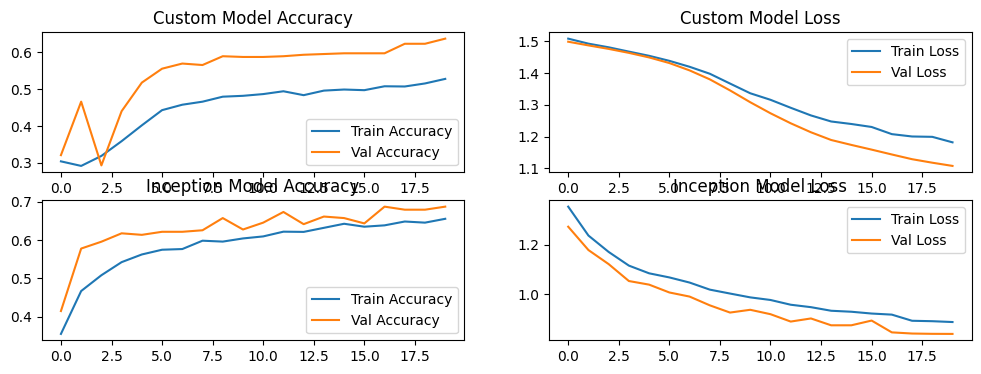

In [10]:
# Train
history_custom = model.fit(
    train_img,
    epochs=20,
    validation_data=valid_img,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

# Initial training while freeze (InceptionV3 Model)
history_inception = inception_model.fit(
    train_img,
    validation_data=valid_img,
    epochs=20,
    callbacks=[early_stopping, reduce_lr, inception_model_checkpoint]
)

# # Unfreeze the top 50 layers of the base InceptionV3 model
# base_model = inception_model.layers[1]  # Access the InceptionV3 model inside Sequential
# base_model.trainable = True
# for layer in base_model.layers[:-50]:
#     layer.trainable = False

# # Recompile with lower learning rate for fine tuning
# inception_model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )

# # Train after unfreeze and fine tuning
# history_finetuned = inception_model.fit(
#     train_img,
#     validation_data=valid_img,
#     epochs=10,
#     callbacks=[early_stopping, reduce_lr, model_checkpoint]
# )

# ---------------------- Plot Training History ----------------------
plt.figure(figsize=(12, 4))
plt.subplot(2, 2, 1)
plt.plot(history_custom.history['accuracy'], label='Train Accuracy')
plt.plot(history_custom.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Custom Model Accuracy')

plt.subplot(2, 2, 2)
plt.plot(history_custom.history['loss'], label='Train Loss')
plt.plot(history_custom.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Custom Model Loss')


plt.subplot(2, 2, 3)
plt.plot(history_inception.history['accuracy'], label='Train Accuracy')
plt.plot(history_inception.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Inception Model Accuracy')

plt.subplot(2, 2, 4)
plt.plot(history_inception.history['loss'], label='Train Loss')
plt.plot(history_inception.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Inception Model Loss')
plt.show()

In [12]:
def evaluate_model(model, valid_img, class_names, model_name="Model"):
    y_true = np.concatenate([y for x, y in valid_img], axis=0)
    y_pred_probs = model.predict(valid_img)
    y_pred = np.argmax(y_pred_probs, axis=1)

    print(f"\n--- {model_name} Classification Report ---")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step

--- Custom CNN Classification Report ---
              precision    recall  f1-score   support

      glioma       0.66      0.97      0.78       161
  meningioma       0.58      0.11      0.19       124
    no_tumor       0.66      0.53      0.58        99
   pituitary       0.60      0.83      0.70       118

    accuracy                           0.64       502
   macro avg       0.63      0.61      0.56       502
weighted avg       0.63      0.64      0.58       502



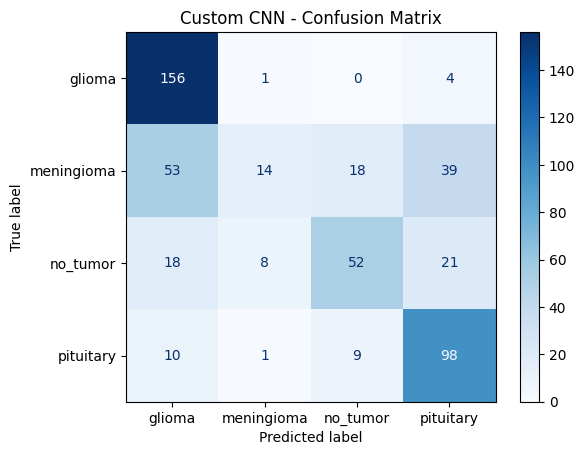

13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 641ms/step

--- InceptionV3 Classification Report ---
              precision    recall  f1-score   support

      glioma       0.71      0.83      0.77       161
  meningioma       0.62      0.23      0.34       124
    no_tumor       0.72      0.78      0.75        99
   pituitary       0.66      0.89      0.76       118

    accuracy                           0.69       502
   macro avg       0.68      0.68      0.65       502
weighted avg       0.68      0.69      0.65       502



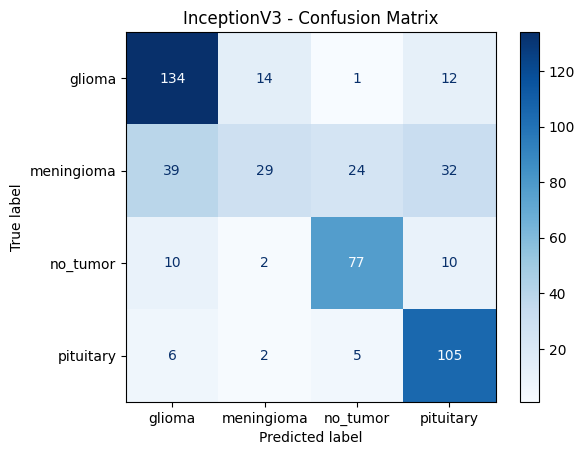

In [13]:
    evaluate_model(model, valid_img, class_names, "Custom CNN")
    evaluate_model(inception_model, valid_img, class_names, "InceptionV3")